In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import r2_score

from statsmodels.api import OLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [2]:
# We will first load the data onto our console and get a first hand feel of how the dataset actually looks like
data = pd.read_csv("day.csv") # Mention the path of your dataset; in my case the csv file is the same directory

In [3]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
data.shape

(730, 16)

In [5]:
data.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [7]:
# The values seem to be appropriate but we need some pre processing and encoding to do before we proceed to our visulization
data.isna().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

In [8]:
# Luckily we dont have any null or missing values to take care off

### Right of the bat we can see some anomalies with dayofweek, the encoding is not proper and the numbers seemed to be messed up; so let's derive new and proper information with dteday

### But it seems like dteday isnt a datetime object so first let's convert  into a datetime object

In [9]:
data["dteday"] = pd.to_datetime(data["dteday"], dayfirst=True)
data.dteday

0     2018-01-01
1     2018-01-02
2     2018-01-03
3     2018-01-04
4     2018-01-05
         ...    
725   2019-12-27
726   2019-12-28
727   2019-12-29
728   2019-12-30
729   2019-12-31
Name: dteday, Length: 730, dtype: datetime64[ns]

In [10]:
# Let's fix our weekday column
data[["weekday", "workingday", "holiday"]].head(20)

,weekday,workingday,holiday
0,6,0,0
1,0,0,0
2,1,1,0
3,2,1,0
4,3,1,0
5,4,1,0
6,5,1,0
7,6,0,0
8,0,0,0
9,1,1,0


### After doing a little bit of research we found that the day starts with Sunday in the US not with Monda, so we have to be careful while mapping some of these values and we can deduce from the workingday and holiday column that "0" and "6" is marked as non-working days and the rest as working days

### So we can label Sunday as 0 till Saturday as 6

### According to this https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html  documentation we will encode Monday as 0 till Sunday as 6 but we cannot use this cause of the reason stated above, so we will stick to Sunday as 0 till Saturday as 6

### Now let's convert some numeic data to categorical data so we can understand the underlying information better in our visualisation 

- The columns to convert into categorical data are :
    - mnth, weekday, weathersit and season
    
### Deciefering "weathersit" can be a bit tricky; according to the data dictionary provided to us the following is the decoded information
 - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

### Just by reading it we can coin our own adjectives to better understand the data in one word
- 1 : Ideal
- 2 : Misty
- 3 : Bad
- 4 : Worse

### For seasons too we will use our data dictionary to coin them
- 1:spring 
- 2:summer
- 3:fall
- 4:winter

In [11]:
data["weekday"] = data["weekday"].map({0: 'sunday', 1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday'})

In [12]:
data["date"] = data["dteday"].dt.day

In [13]:
data["mnth"] = data["dteday"].dt.month_name()

In [14]:
data["weekday"] = data["dteday"].dt.day_name()

In [15]:
data["weathersit"] = data["weathersit"].map({1 : "Ideal", 2 : "Misty", 3 : "Bad", 4 : "Worse"})

In [16]:
data["season"] = data["season"].map({1:"spring", 2:"summer", 3:"fall", 4:"winter"})

#### Also let's round off our numerical variables to 2 decimal
 - temp, atemp, hum. windspeed

In [17]:
cols_to_roundoff = ["temp", "atemp", "hum", "windspeed"]

data[cols_to_roundoff] = round(data[cols_to_roundoff], 2)

In [18]:
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,date
0,1,2018-01-01,spring,0,January,0,Monday,0,Misty,14.11,18.18,80.58,10.75,331,654,985,1
1,2,2018-01-02,spring,0,January,0,Tuesday,0,Misty,14.90,17.69,69.61,16.65,131,670,801,2
2,3,2018-01-03,spring,0,January,0,Wednesday,1,Ideal,8.05,9.47,43.73,16.64,120,1229,1349,3
3,4,2018-01-04,spring,0,January,0,Thursday,1,Ideal,8.20,10.61,59.04,10.74,108,1454,1562,4
4,5,2018-01-05,spring,0,January,0,Friday,1,Ideal,9.31,11.46,43.70,12.52,82,1518,1600,5


### We will drop the columns which we dont need
- instant : This is just the record number and clearly is of no use
- dteday : Most of the information from this column have been derived in other columns, so this holds little to no value and would be redundant
- casual & registered : We will assume we dont know these values while the model predicts on new data and our target -value is simply the sum of these two columns so when we include these in our model, the model will memorize these value and fail to generalize on the given data, in simple term these two values will leak information of our targeted variable

In [19]:
cols_to_drop = ["dteday", "instant", "casual", "registered"]
data.drop(cols_to_drop, axis = 1, inplace  = True)
data.head()



,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date
0,spring,0,January,0,Monday,0,Misty,14.11,18.18,80.58,10.75,985,1
1,spring,0,January,0,Tuesday,0,Misty,14.90,17.69,69.61,16.65,801,2
2,spring,0,January,0,Wednesday,1,Ideal,8.05,9.47,43.73,16.64,1349,3
3,spring,0,January,0,Thursday,1,Ideal,8.20,10.61,59.04,10.74,1562,4
4,spring,0,January,0,Friday,1,Ideal,9.31,11.46,43.70,12.52,1600,5


In [20]:
# Just to run a final check if there are some anomalies 
data[data["windspeed"] <= 0]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date


In [21]:
data[data["temp"] <= 0]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date


In [22]:
data[data["hum"] == 0]

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt,date
68,spring,0,March,0,Saturday,1,Bad,15.95,19.28,0.0,17.55,623,10


## Observations :
- This is practially impossible to happen, because the earth's atmosphere contains water vapour  given the weather conditions on earth
- Resource : https://www.google.com/search?client=firefox-b-d&q=can+humidity+be+zero

In [23]:
# Let's remove this data

data = data[data["hum"] != 0.0]

## Data visualisation (EDA)
- Check for outliers
- Check for some collinearity
- Identify and deduce some patterns which helps us to understand the data

In [24]:
# Let's define a function for our uni-variate, bi-variate and multi-variate(More than three) analysis

def plots(x = None, y = None, hues = None, rotation = 0, bar_plot = False, box_plot = False, count_plot = False,
         figsisze = (17, 5), fontsize = 10, dataframe = data):
    
    if bar_plot:
        sns.barplot(x = x, y = y, hue = hues, data = dataframe)
        plt.gcf().set_size_inches(figsisze)
        plt.title(label = f"Bar plot between {x} and {y}",fontdict = {"fontsize" : fontsize})
        plt.xlabel(xlabel = str(x), fontsize = fontsize)
        plt.ylabel(ylabel = str(y), fontsize = fontsize)
        plt.xticks(fontsize = fontsize, rotation = rotation)
        plt.yticks(fontsize = fontsize)
    
    elif box_plot :
        sns.boxplot(x = x, y = y, hue = hues, data = dataframe)
        plt.gcf().set_size_inches(figsisze)
        plt.title(label = f"Box plot between {x} and {y}",fontdict = {"fontsize" : fontsize})
        plt.xlabel(xlabel = str(x), fontsize = fontsize)
        plt.ylabel(ylabel = str(y), fontsize = fontsize)
        plt.xticks(fontsize = fontsize, rotation = rotation)
        plt.yticks(fontsize = fontsize)
 
    elif count_plot:
        sns.countplot(x = x, hue = hues, data = dataframe)
        plt.gcf().set_size_inches(figsisze)
        plt.title(label = f"Count plot between {x} and {y}",fontdict = {"fontsize" : fontsize})
        plt.xlabel(xlabel = str(x), fontsize = fontsize)
        plt.ylabel(ylabel = str(y), fontsize = fontsize)
        plt.xticks(fontsize = fontsize, rotation = rotation)
        plt.yticks(fontsize = fontsize)
    
    else :
        print("Please set the Boolean value to True for any of the following plots : \n  [bar_plot, box_plot, count_plot]")


## Checking for outliers

### Since we have only four numerical columns it will be a short work considering that there wont be annoying outliers

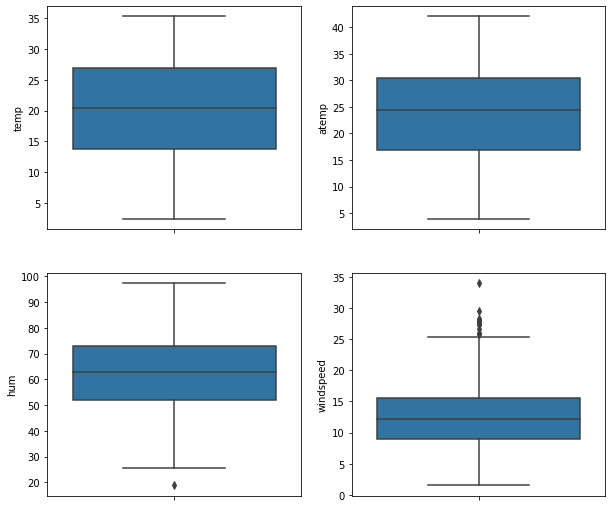

In [25]:
cols_for_boxplot = ["temp", "atemp", "hum", "windspeed"]
plt.gcf().set_size_inches(10,9)
for i,j in enumerate(cols_for_boxplot):
    plt.subplot(2,2,i+1)
    sns.boxplot(data = data, y = j)
#Let's drop "atemp" too, since its colienarity may create some problem for us   
data.drop("atemp", axis = 1, inplace = True)

## Observations :
- There arent any annoying outlier so no need to change or delete any rows

## Checking for some collinearity

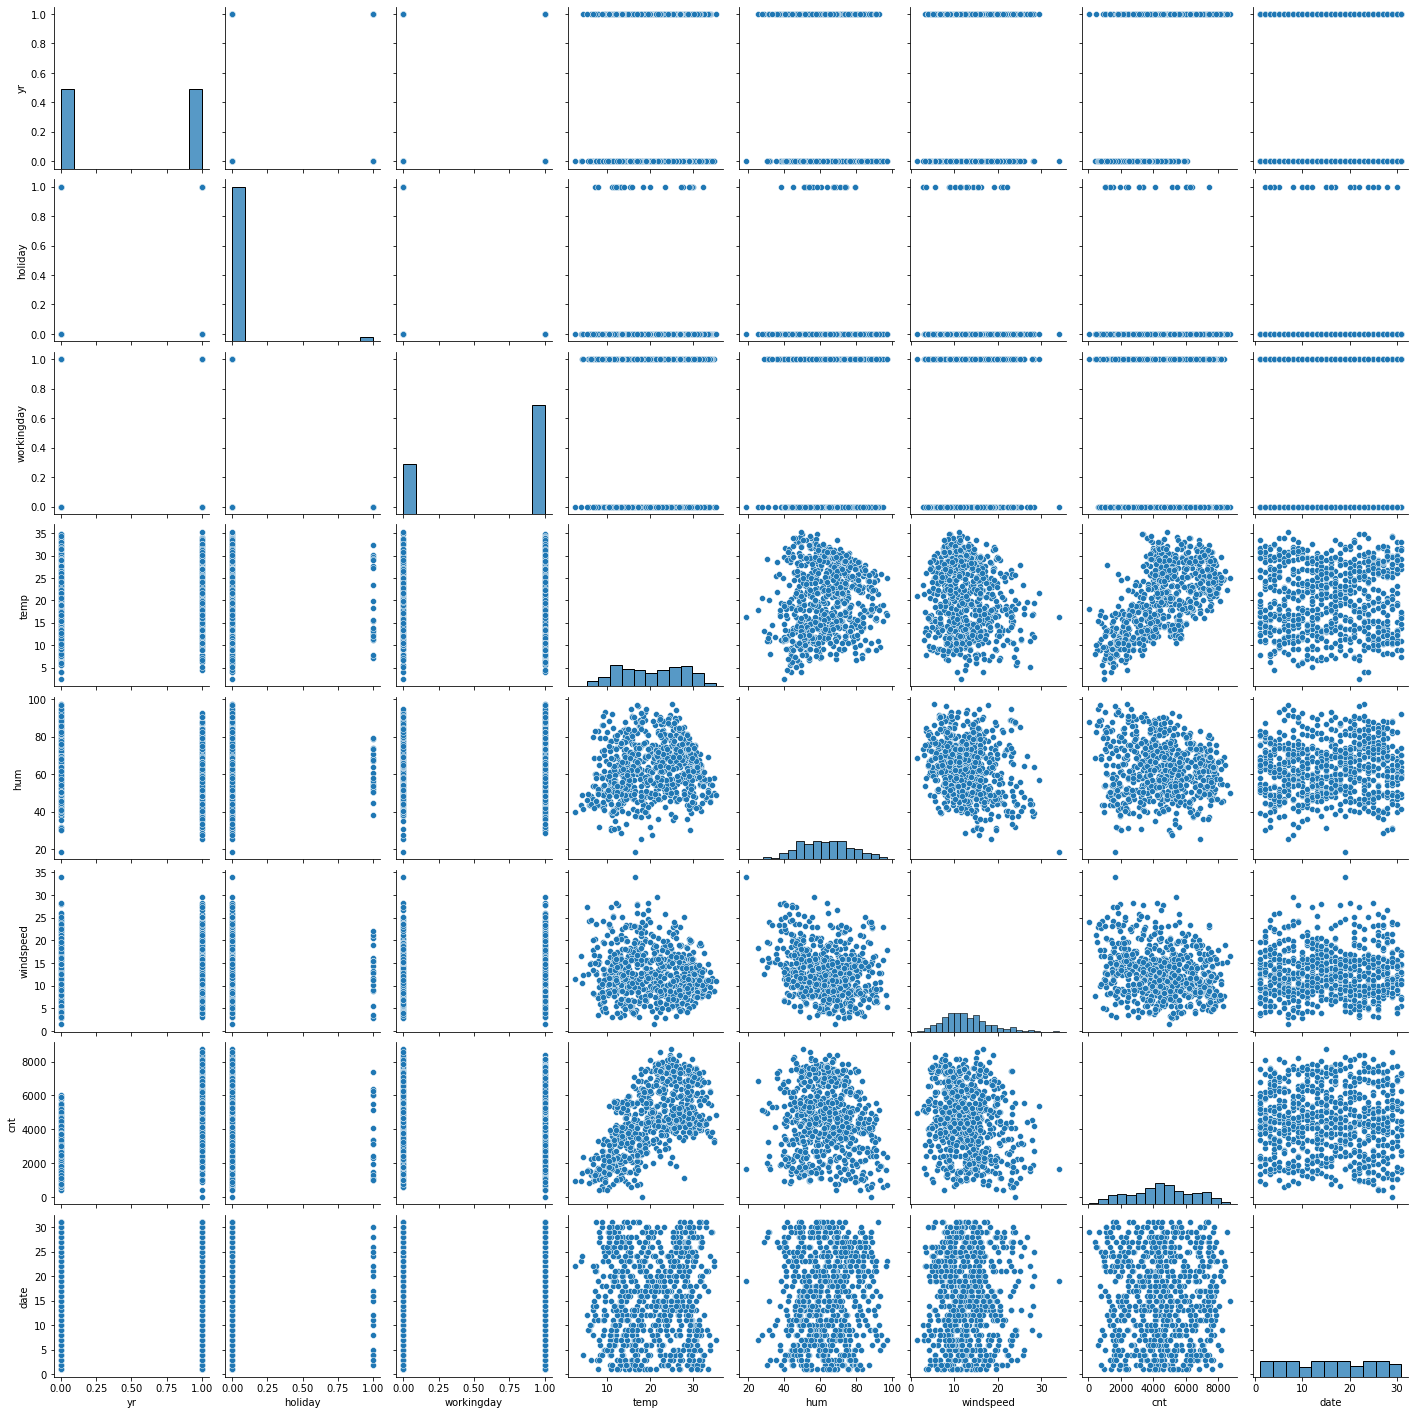

In [26]:
# We will use pairplot to achieve this along with heatmaps

sns.pairplot(data)

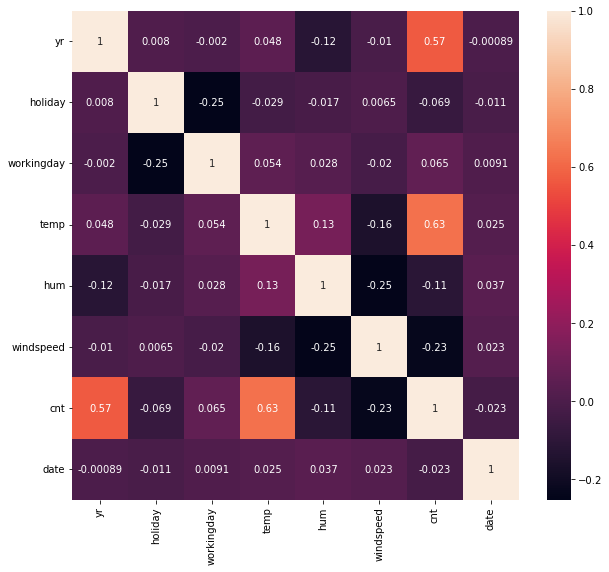

In [27]:
sns.heatmap(data.corr(), annot = True)
plt.gcf().set_size_inches(10,9)

## Observation :
- temp and atemp shows high collinearity, this could be a problem while building our model
- Also there exists some linear relationship between temp and cnt, atemp and cnt
- A psoitive corelation can be observed between yr and cnt as well

## Let's visualise our data using bivariate and multi variate analysis

In [28]:
data.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'cnt', 'date'],
      dtype='object')

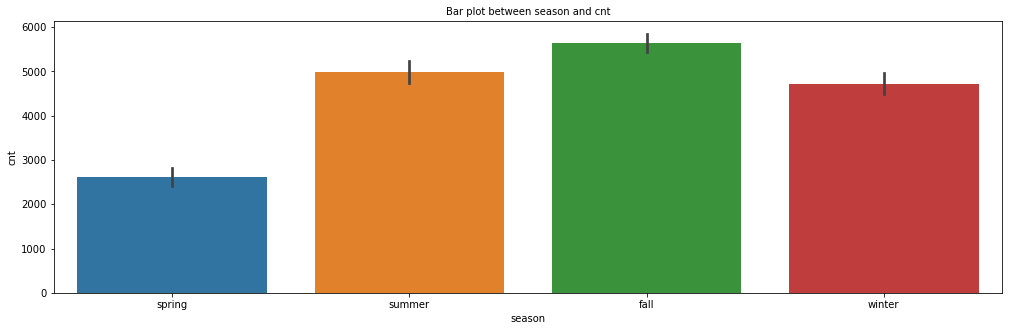

In [29]:
x = "season"
y = "cnt"

plots(x = x, y = y, bar_plot = True)

## Observations :
- Fall and summer shows the highest count 
- This could be due to the summer vacation which typicall lasts for 2 and a half months
- Some students also prefer riding bikes to school which can explain the rise in count in fall

Text(0.5, 0, 'yr, 0 : 2018, 1 : 2019')

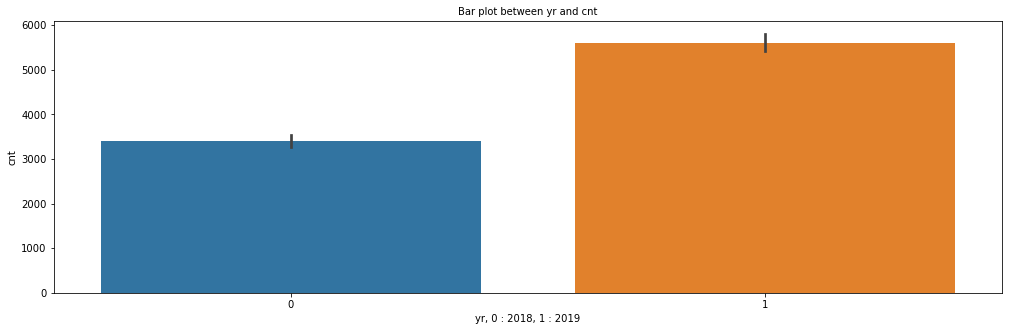

In [30]:
x = "yr"
y = "cnt"

plots(x = x, y = y, bar_plot = True)
plt.xlabel("yr, 0 : 2018, 1 : 2019")

## Observations :
- The busness is growing for Boombikes in 2019 which is a good indicator

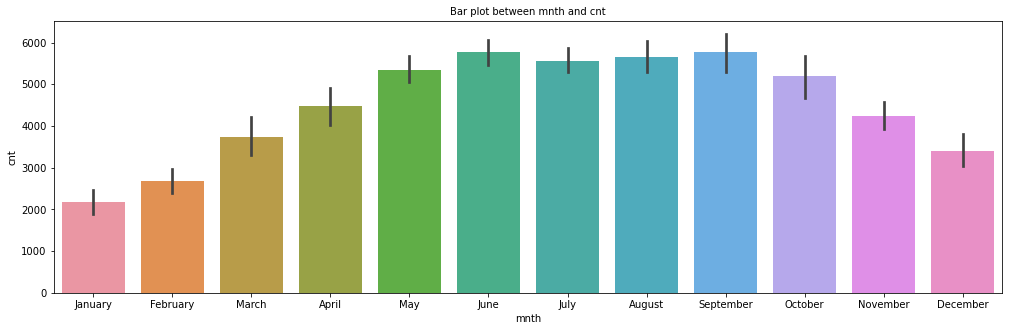

In [31]:
x = "mnth"
y = "cnt"

plots(x = x, y = y, bar_plot = True)

## Observations :
- summer runs from June 1 to August 31; fall (autumn) runs from September 1 to November 30 which explains the higher bike count in those months
- resource :https://www.google.com/search?client=firefox-b-d&q=summer+and+fall+in+US

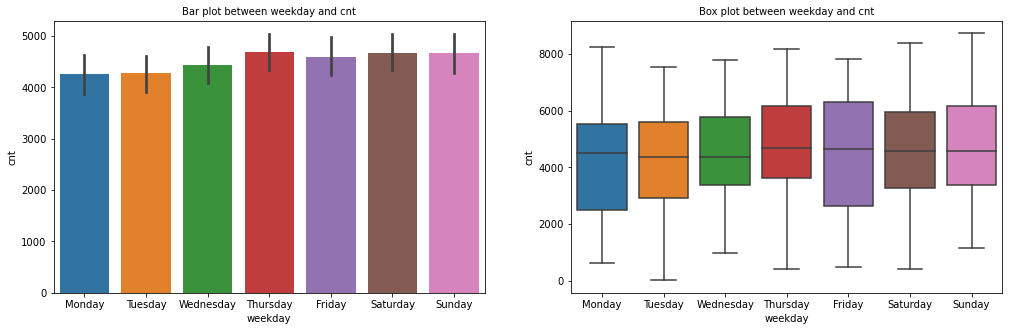

In [32]:
x = "weekday"
y = "cnt"
plt.subplot(121)
plots(x = x, y = y, bar_plot = True)

plt.subplot(122)
plots(x = x, y = y, box_plot = True)

## Observations:
- It seems that the count is evenly distributed accross the days of the week
- no specific apttern observed

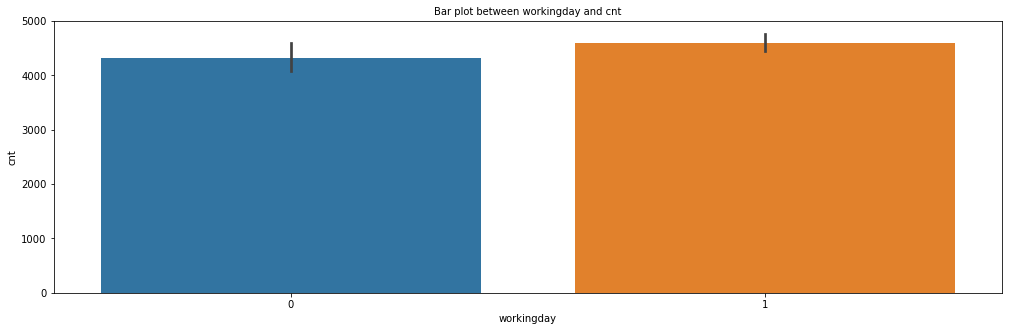

In [33]:
x = "workingday"
y = "cnt"

plots(x = x, y = y, bar_plot = True)


## Observations :
- People who tend to be working tend have a higher bike count

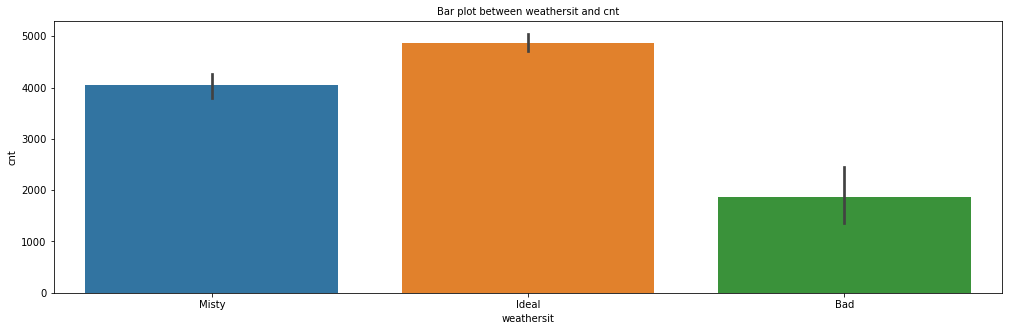

In [34]:
x = "weathersit"
y = "cnt"

plots(x = x, y = y, bar_plot = True)


## Observations :
- People tend to ride bikes when the weather is misty or ideal which makes sense given that the weather condition palys a mojor role in deciding to whether ride a bike or not

In [35]:
data.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'hum', 'windspeed', 'cnt', 'date'],
      dtype='object')

## Let's start with buidling our model

### Pre-processing the data

In [36]:
# Let's first convert the categorical variables into dummy variables
cat_cols = ["season", "mnth", "weekday", "weathersit"]

dummy_vars = pd.get_dummies(data[cat_cols], drop_first=True)

dummy_vars.head()

,season_spring,season_summer,season_winter,mnth_August,mnth_December,mnth_February,mnth_January,mnth_July,mnth_June,mnth_March,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Ideal,weathersit_Misty
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
2,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
3,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [37]:
dummy_vars.columns

Index(['season_spring', 'season_summer', 'season_winter', 'mnth_August',
       'mnth_December', 'mnth_February', 'mnth_January', 'mnth_July',
       'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November', 'mnth_October',
       'mnth_September', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weathersit_Ideal', 'weathersit_Misty'],
      dtype='object')

In [38]:
# All the dummy variable have been created and now we need to concat this to the copy of our original data

data1 = data.copy()

data1 = pd.concat([data1, dummy_vars], axis = 1)
data1.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,hum,windspeed,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Ideal,weathersit_Misty
0,spring,0,January,0,Monday,0,Misty,14.11,80.58,10.75,...,0,0,1,0,0,0,0,0,0,1
1,spring,0,January,0,Tuesday,0,Misty,14.90,69.61,16.65,...,0,0,0,0,0,0,1,0,0,1
2,spring,0,January,0,Wednesday,1,Ideal,8.05,43.73,16.64,...,0,0,0,0,0,0,0,1,1,0
3,spring,0,January,0,Thursday,1,Ideal,8.20,59.04,10.74,...,0,0,0,0,0,1,0,0,1,0
4,spring,0,January,0,Friday,1,Ideal,9.31,43.70,12.52,...,0,0,0,0,0,0,0,0,1,0


In [39]:
# Now let's drop the original columns in data1 

data1.drop(cat_cols, axis = 1, inplace = True)
data1.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'hum', 'windspeed', 'cnt',
       'date', 'season_spring', 'season_summer', 'season_winter',
       'mnth_August', 'mnth_December', 'mnth_February', 'mnth_January',
       'mnth_July', 'mnth_June', 'mnth_March', 'mnth_May', 'mnth_November',
       'mnth_October', 'mnth_September', 'weekday_Monday', 'weekday_Saturday',
       'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday',
       'weekday_Wednesday', 'weathersit_Ideal', 'weathersit_Misty'],
      dtype='object')

## Splitting the data into train and test set (70% for training and 30% for testing)

In [40]:
train_df, test_df = train_test_split(data1, train_size = 0.7, random_state = 42)
print(train_df.shape)
print(test_df.shape)

(510, 30)
(219, 30)


In [41]:
# Scaling our numerical variables
num_cols = ["temp", "hum", "windspeed", "cnt"]
scaler = MinMaxScaler()

data1[num_cols] = scaler.fit_transform(data1[num_cols])
data1[num_cols]

# We wont touch other varaibles sicne they are already have taken values from 0 and 1

,temp,hum,windspeed,cnt
0,0.355211,0.787535,0.284615,0.110792
1,0.379216,0.647719,0.466154,0.089623
2,0.171073,0.317869,0.465846,0.152669
3,0.175631,0.513000,0.284308,0.177174
4,0.209359,0.317487,0.339077,0.181546
...,...,...,...,...
725,0.243087,0.592659,0.675692,0.240681
726,0.242176,0.512490,0.274462,0.353543
727,0.242176,0.720112,0.210154,0.151749
728,0.245214,0.376498,0.676923,0.204096


In [42]:
data1[num_cols].describe()

,temp,hum,windspeed,cnt
count,729.000000,729.000000,729.000000,729.000000
mean,0.544069,0.561575,0.346373,0.516721
std,0.228205,0.179148,0.159882,0.222271
min,0.000000,0.000000,0.000000,0.000000
25%,0.345792,0.423273,0.232000,0.364473
50%,0.549377,0.559266,0.327077,0.520824
75%,0.743543,0.690925,0.434462,0.684998
max,1.000000,1.000000,1.000000,1.000000


In [43]:
# All the numeical columns were successfully scaled

## Data Modelling

In [44]:
y_train = data1.pop("cnt")
X_train = data1

In [45]:
X_train

,yr,holiday,workingday,temp,hum,windspeed,date,season_spring,season_summer,season_winter,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Ideal,weathersit_Misty
0,0,0,0,0.355211,0.787535,0.284615,1,1,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0,0,0,0.379216,0.647719,0.466154,2,1,0,0,...,0,0,0,0,0,0,1,0,0,1
2,0,0,1,0.171073,0.317869,0.465846,3,1,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0,0,1,0.175631,0.513000,0.284308,4,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0,0,1,0.209359,0.317487,0.339077,5,1,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,1,0.243087,0.592659,0.675692,27,1,0,0,...,0,0,0,0,0,0,0,0,0,1
726,1,0,1,0.242176,0.512490,0.274462,28,1,0,0,...,0,0,0,1,0,0,0,0,0,1
727,1,0,0,0.242176,0.720112,0.210154,29,1,0,0,...,0,0,0,0,1,0,0,0,0,1
728,1,0,0,0.245214,0.376498,0.676923,30,1,0,0,...,0,0,1,0,0,0,0,0,1,0


In [46]:
y_train

0      0.110792
1      0.089623
2      0.152669
3      0.177174
4      0.181546
         ...   
725    0.240681
726    0.353543
727    0.151749
728    0.204096
729    0.311436
Name: cnt, Length: 729, dtype: float64

### We will use RFE approach since the manual approach will be cumbersome and from there we can use our RFE model to sort of fine tune our model

#### For RFE approach we need Sklearns Linear regression

In [47]:
regressor = LinearRegression()
#regressor.fit(X_train, y_train)

In [48]:
rfe = RFE(regressor, n_features_to_select = 19)
rfe_model = rfe.fit(X_train, y_train)

In [49]:
rfe_data = pd.DataFrame()
rfe_data["columns"] = X_train.columns
rfe_data["support"] = rfe_model.support_
rfe_data["rank"] = rfe_model.ranking_

In [50]:
rfe_data.sort_values(by = "rank")

,columns,support,rank
0,yr,True,1
26,weekday_Wednesday,True,1
25,weekday_Tuesday,True,1
21,weekday_Monday,True,1
20,mnth_September,True,1
18,mnth_November,True,1
17,mnth_May,True,1
27,weathersit_Ideal,True,1
13,mnth_January,True,1
12,mnth_February,True,1


In [51]:
# It's easy to extract the coloumn we want to use based on support and ranking 
rfe_features = [i for i in rfe_data[rfe_data["rank"] == 1]["columns"]]
rfe_features

['yr',
 'holiday',
 'temp',
 'hum',
 'windspeed',
 'season_spring',
 'season_winter',
 'mnth_December',
 'mnth_February',
 'mnth_January',
 'mnth_July',
 'mnth_May',
 'mnth_November',
 'mnth_September',
 'weekday_Monday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'weathersit_Ideal',
 'weathersit_Misty']

In [52]:
# Let's define two funtions, one which build our OLS model and the otehr to calculate our VIF score

def OLS_model(X_train_cols, y_train = y_train, return_model = False):
    
    X_train_sm = sm.add_constant(X_train[X_train_cols])
    model = OLS(y_train, X_train_sm)
    ols_model = model.fit()
    
    if return_model:
        return ols_model
    
    else:
        print(ols_model.summary())
        
def vif_score(X):
    vif = pd.DataFrame()
    vif["Features"] = X.columns
    vif["VIF"] = [round(variance_inflation_factor(X.values, i),2) for i in range(X.shape[1])]
    
    return vif.sort_values(by = "VIF", ascending = False)
    

In [53]:
# We now dont need to hardcode everytime we wanna build a model using statsmodel

## Building our OLS model using RFE approach

In [54]:
# We will have a temporary variable to store our changes

X_train_rfe = X_train.columns[rfe.support_]

OLS_model(X_train_cols = X_train_rfe)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     205.3
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          6.42e-273
Time:                        19:30:18   Log-Likelihood:                 744.78
No. Observations:                 729   AIC:                            -1450.
Df Residuals:                     709   BIC:                            -1358.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.1610      0.03

In [55]:
vif_score(X = X_train[X_train_rfe])

,Features,VIF
2,temp,22.56
3,hum,14.92
17,weathersit_Ideal,14.15
18,weathersit_Misty,7.94
4,windspeed,5.16
5,season_spring,5.08
6,season_winter,3.05
9,mnth_January,2.44
8,mnth_February,2.17
0,yr,2.05


## Observations :
- The VIF temp but the P-values seem to be in check
- We will elimniate high p-value then check our VIF

### We will obviously not rely on these features and perform our own manual approach and during which we may end up with lesser features

## Model 1 : Removing weekday_wednesday due to its high p-value

In [56]:
X_train_rfe = X_train[rfe_features].drop("weekday_Wednesday", axis = 1)
OLS_model(X_train_cols = X_train_rfe.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     215.8
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          2.26e-273
Time:                        19:30:18   Log-Likelihood:                 743.07
No. Observations:                 729   AIC:                            -1448.
Df Residuals:                     710   BIC:                            -1361.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1603      0.037  

In [57]:
vif_score(X = X_train_rfe)

,Features,VIF
2,temp,22.53
3,hum,14.81
16,weathersit_Ideal,14.04
17,weathersit_Misty,7.91
4,windspeed,5.16
5,season_spring,5.08
6,season_winter,3.05
9,mnth_January,2.44
8,mnth_February,2.17
0,yr,2.05


## Model 2 Removing "hum" due to high VIF score

In [58]:
X_train_rfe = X_train_rfe.drop("hum", axis = 1)
OLS_model(X_train_cols = X_train_rfe.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     217.9
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          3.36e-268
Time:                        19:30:18   Log-Likelihood:                 728.00
No. Observations:                 729   AIC:                            -1420.
Df Residuals:                     711   BIC:                            -1337.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0354      0.030  

In [59]:
vif_score(X = X_train_rfe)

,Features,VIF
2,temp,15.01
15,weathersit_Ideal,13.99
16,weathersit_Misty,7.50
3,windspeed,5.15
4,season_spring,4.76
5,season_winter,2.69
8,mnth_January,2.37
7,mnth_February,2.16
0,yr,2.03
11,mnth_November,1.82


## Model 3 : Removing "mnth_May" due to its high p-value 

In [60]:

X_train_rfe = X_train_rfe.drop("mnth_May", axis = 1)
OLS_model(X_train_cols = X_train_rfe.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     230.9
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          7.27e-269
Time:                        19:30:18   Log-Likelihood:                 726.76
No. Observations:                 729   AIC:                            -1420.
Df Residuals:                     712   BIC:                            -1341.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0398      0.030  

In [61]:
vif_score(X = X_train_rfe)

,Features,VIF
2,temp,14.93
14,weathersit_Ideal,13.82
15,weathersit_Misty,7.37
3,windspeed,5.15
4,season_spring,4.64
5,season_winter,2.59
8,mnth_January,2.37
7,mnth_February,2.16
0,yr,2.03
10,mnth_November,1.82


## Model 4 : Removing  "weathersit_Misty" due to its high VIF score

In [62]:
X_train_rfe = X_train_rfe.drop("weathersit_Misty", axis = 1)
OLS_model(X_train_cols = X_train_rfe.columns)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     214.0
Date:                Wed, 05 Oct 2022   Prob (F-statistic):          6.24e-252
Time:                        19:30:19   Log-Likelihood:                 683.90
No. Observations:                 729   AIC:                            -1336.
Df Residuals:                     713   BIC:                            -1262.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2315      0.023  

In [63]:
vif_score(X = X_train_rfe)

,Features,VIF
2,temp,6.18
3,windspeed,4.87
4,season_spring,4.18
14,weathersit_Ideal,2.81
5,season_winter,2.42
8,mnth_January,2.26
7,mnth_February,2.12
0,yr,2.01
10,mnth_November,1.78
6,mnth_December,1.57


### Our model has low P-values and considerable low VIF value except for temp, well there are two school of thoughts:
- One is that we follow a general rule of thumb and eliminate all the features having VIF value greater than 5 

### OR


-  We take a decision based on our knowledge and the understanding of such data from our EDA and clearly from the resource https://www.netatmo.com/en-row/guides/weather/weather-factors/faq/wind-speed-effect windspeed does have an effect on the temperature a little bit

- ### We did try to eliminate the windspeed but then again it should have little to no affect on our accuracy, or we simply can use other advanced method like PCA  to eliminate collinearity but for this case we will stick to this approach



### Now Let's proceed with the evaluation of our model on the training set and validate some of the assumptions of Linear Regressions

In [64]:
lr_model = OLS_model(X_train_cols = X_train_rfe.columns,return_model=True)
# This is after dropping weathersit_Misty

feature_selected = vif_score(X = X_train_rfe)
X_train_rfe

,yr,holiday,temp,windspeed,season_spring,season_winter,mnth_December,mnth_February,mnth_January,mnth_July,mnth_November,mnth_September,weekday_Monday,weekday_Tuesday,weathersit_Ideal
0,0,0,0.355211,0.284615,1,0,0,0,1,0,0,0,1,0,0
1,0,0,0.379216,0.466154,1,0,0,0,1,0,0,0,0,1,0
2,0,0,0.171073,0.465846,1,0,0,0,1,0,0,0,0,0,1
3,0,0,0.175631,0.284308,1,0,0,0,1,0,0,0,0,0,1
4,0,0,0.209359,0.339077,1,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,0.243087,0.675692,1,0,1,0,0,0,0,0,0,0,0
726,1,0,0.242176,0.274462,1,0,1,0,0,0,0,0,0,0,0
727,1,0,0.242176,0.210154,1,0,1,0,0,0,0,0,0,0,0
728,1,0,0.245214,0.676923,1,0,1,0,0,0,0,0,1,0,1


## Assumptions of Linear Regressions are as follows :
- There should exist some lienar relationship between X and Y
- The error terms should be normall distributed
- The error terms should be independent of each other
- The error terms must show constant variation (Homoscedasticity)

### 1) We already proved that there exists some linear relationship earlier on in the notebook


### 2) The error terms should be normally distributed around 0

In [65]:
X_train_rfe_sm = sm.add_constant(X_train_rfe)

y_train_pred = lr_model.predict(X_train_rfe_sm)
residuals = y_train - y_train_pred

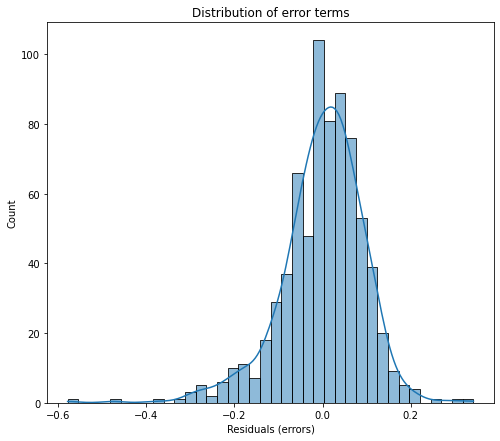

In [66]:
sns.histplot(residuals, kde = True)
plt.title("Distribution of error terms")
plt.xlabel("Residuals (errors)")
plt.gcf().set_size_inches(8,7)

## Observations :
- As one can see that the error terms are normally distributed around 0, hence we have proved  our second assumption

### 3) Error terms are independent of each other

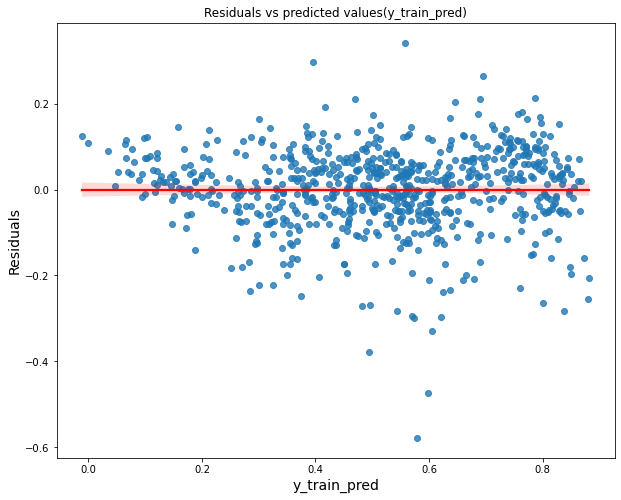

In [67]:
sns.regplot(x = y_train_pred, y = residuals, line_kws = {"color" : "red"})
plt.title("Residuals vs predicted values(y_train_pred)")
plt.xlabel("y_train_pred", fontdict={"fontsize" : 14})
plt.ylabel("Residuals", fontdict={"fontsize" : 14})
plt.gcf().set_size_inches(10,8)

## Observations :
- There is almost no relation between y_train_pred and the Residuals and possess no such obvious pattern, this shows that the error terms are indeed independent

### 4) Error terms have constant co variance

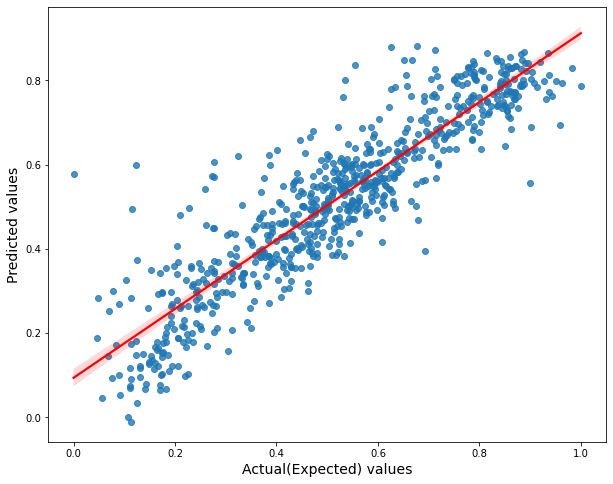

In [68]:
sns.regplot(x = y_train, y = y_train_pred, line_kws = {"color" : "red"})
plt.title("")
plt.xlabel("Actual(Expected) values", fontdict={"fontsize" : 14})
plt.ylabel("Predicted values", fontdict={"fontsize" : 14})
plt.gcf().set_size_inches(10,8)

## Observations :
- Our predicted values follows the same trend as that of our Actual values and it is spread out evenly across the actual value

### We have proved all the assumption of Linear Regression and its time to actually test our model on the test set and see how it performs

## Evaluating our model on the Test set

In [69]:
test_df

,yr,holiday,workingday,temp,hum,windspeed,cnt,date,season_spring,season_summer,...,mnth_October,mnth_September,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,weathersit_Ideal,weathersit_Misty
469,1,0,0,24.87,50.79,15.08,7132,15,0,1,...,0,0,1,0,0,0,0,0,1,0
149,0,1,0,30.07,68.50,8.79,4098,30,0,1,...,0,0,0,0,0,0,0,1,1,0
303,0,0,1,13.94,70.33,7.13,3669,31,0,0,...,1,0,0,0,0,0,0,1,1,0
356,0,0,1,15.31,68.62,18.37,2209,23,1,0,...,0,0,0,0,1,0,0,0,1,0
516,1,0,1,26.82,75.54,15.92,4127,1,0,1,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333,0,0,1,13.32,61.33,18.17,3613,30,0,0,...,0,0,0,0,0,0,0,0,1,0
533,1,0,1,23.30,77.79,11.71,5099,18,0,1,...,0,0,0,0,0,0,1,0,0,1
559,1,0,0,28.84,69.92,9.63,6969,14,0,0,...,0,0,0,0,1,0,0,0,0,1
138,0,0,1,21.76,82.96,7.25,4575,19,0,1,...,0,0,0,1,0,0,0,0,0,1


### Pre- processing our Test set

In [70]:
# We have to scale these features using the same class object we used to scale our training data
test_df_copy = test_df.copy()

In [71]:
test_df_copy[num_cols] = scaler.transform(test_df_copy[num_cols])
# We used transform as we want to scale the values and not find the minimum and maximum value of test set

In [72]:
test_df_copy[num_cols].describe()

,temp,hum,windspeed,cnt
count,219.000000,219.000000,219.000000,219.000000
mean,0.526127,0.546541,0.359340,0.492027
std,0.230976,0.183567,0.170647,0.217070
min,0.047706,0.000000,0.040923,0.000000
25%,0.337587,0.407086,0.248154,0.310918
50%,0.504710,0.531608,0.334462,0.489185
75%,0.734731,0.659317,0.438462,0.629084
max,0.970830,1.000000,1.000000,0.981707


## Inference :
- Its no worry that we see dont see the exact minimum and maximum value this is because our class object "scaler" use to scale our test uses the minimum and maximum value of our training set

### Spliting the test data into X_test(test set which our model will use to predict) and y_test(Expedcted values)


In [76]:
y_test = test_df_copy.pop("cnt")
X_test = test_df_copy

In [77]:
print(X_test.shape)
print(y_test.shape)

(219, 29)
(219,)


### We will keep the columns which we need and drop the rest just like we did with our training data
- ### Columns which we will keep are :
    - Temp
    - windspeed
    - season_spring
    - weathersit_Ideal
    - season_winter
    - mnth_January
    - mnth_February
    - yr
    - mnth_November
    - mnth_December
    - mnth_July
    - mnth_September
    - weekday_Monday
    - weekday_Tuesday
    - holiday

In [91]:
X_test = X_test[X_train_rfe.columns] # All the preprocessing of the test set has been done 

## Predicting the values of test set

In [93]:
X_test_sm = sm.add_constant(X_test)

y_test_pred = lr_model.predict(X_test_sm)

In [95]:
r2_score(y_true = y_test, y_pred = y_test_pred)

0.8127172301061806